# Projekt NLP - Clustering

Dieses Notebook enthält den Code sowie die Analyse des Clusterings. 

In [1]:
import os
import re
import json
import pickle as pk
from random import randint
from datetime import datetime
from IPython.display import display, clear_output
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import plotly
import plotly.express as px
import plotly.graph_objs as go

import nltk
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("de_core_news_sm")
from spacy.lang.de.stop_words import STOP_WORDS
import snowballstemmer

from wordcloud import WordCloud
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import statsmodels

In [2]:
with open("articles.json", "r") as f:
    articles = json.load(f)

In [3]:
articles

[{'article_url': 'https://www.heise.de/news/Telekom-und-Apple-starten-Augmented-Reality-Innovationsprogramm-6147126.html',
  'number_comments': 0,
  'date': '07-26-2021, 16:01',
  'brandig': ['Mac & i'],
  'related_topics': ['5G',
   'Apple',
   'Augmented Reality',
   'Deutsche Telekom',
   'Innovation',
   'iOS',
   'iPhone',
   'Mobilfunk',
   'Startups',
   'Wettbewerb'],
  'authors': ['Ben Schwan'],
  'heading': 'Telekom und Apple starten Augmented-Reality-Innovationsprogramm',
  'lead': 'Im Rahmen des Start-up-Inkubators "Hubraum" können sich Entwickler in sechs Kategorien bewerben, um Apples AR-Technik mit 5G und Co. zu kombinieren.',
  'atricle_text': 'Die Deutsche Telekom AG hat zusammen mit ihrer US-Tochter T-Mobile sowie Apple ein Innovationsprogramm für Augmented Reality (AR) aufgelegt. Die Kampagne läuft im Rahmen des Telekom-Inkubators Hubraum mit Sitz in Deutschland und ist international angelegt. Bewerbungen sind noch bis zum 4. August möglich, danach wird es für die in

# Zweck und Aufbau des Notebooks

In diesem Notebook werden die Leads als auch die Texte mittels des KMeans-Algorithmus geclustert, analysiert und mit den verwandten Themen verglichen.

Um die Ausführungszeit des Notebooks zu beschleunigen, wurden Codezeilen, die eine Berechnungszeit von mehreren Stunden hatten, auskommentiert und die Ergebnisse jeweils als .pkl-Datei gespeichert. Diese Dateien müssen folglich nur noch geladen werden.

Zu Beginn wird, wie bereits erwähnt, mit den kurzen Zusammenfassungen (Leads) der Artikel gearbeitet, dies ist deutlich schneller, da die richtigen Artikel viel mehr Text und somit ein wesentlich größeres Vokabular enthalten. Im Weiteren werden auch die kompletten Artikel analysiert, diese jedoch deutlich reduzierter. 
Bevor die Daten geclustert werden können, werden Sie vorverarbeitet, es werden störende Zeichen und Stopwörter entfernt. Es folgt Stemming oder Lemmatisierung. In diesem Notebook wird beides aufgeführt, jedoch nur wirklich mit den lemmatisierten Daten gearbeitet. Im nächsten Schritt werden die einzelnen Leads vektorisiert, dies erfolgt durch Tfidf-Vektorisierung. Nach diesem Abschnitt sind die Daten für das Clustering vollständig vorbereitet. 
Um nun das Modell auf die Daten optimal anpassen zu können, wurde mit Hilfe der Ellenbogen-Methode die optimale Menge an Clustern gesucht. Dies wurde sowohl mit den gestemmten als auch mit den lemmatisierten Daten durchgeführt, mit einem sehr ähnlichen Ergebnis. 
Es folgt die Reduktion der Dimensionen durch eine PCA. Mit zunehmender Anzahl der Dimensionen einer Datenmenge wird es immer schwieriger, sie zu verarbeiten. Deshalb ist es manchmal sinnvoll die Dimensionen zu reduzieren. Eine Möglichkeit Dimensionen zu reduzieren ist relevante Informationen zu extrahieren und den Rest der Daten als Rauschen zu entsorgen. Dies ist hier nur schwer möglich, weshalb mit PCA gearbeitet wird. Die Ergebnisse des Clusterings mit den Feature reduzierten Daten ist jedoch nicht besonders aussagekräftig, weshalb weiter mit den lemmatisierten Daten gearbeitet wird.


Es folgt die Clusteranalyse. Hierfür gibt es verschiedenste Ansätze, welche jeweils ihre eigenen Vor- und Nachteile besitzen. Außerdem führen sie zu verschiedenen Ergebnissen - sprich Klassen von Clustern. Als Grundlage für das Clustering verwenden sie jedoch alle Distanz (Unähnlichkeit) und Ähnlichkeit. Bei quantitativen Merkmalen wird dabei die Distanz bevorzugt, um die Beziehung zwischen den einzelnen Datenpunkten zu erkennen. Die Ähnlichkeit wiederum wird bevorzugt, wenn es um qualitative Merkmale geht. In diesem Fall wird mit der Distanz gearbeitet. 
Die Analyse Methoden können in zwei verschiedene Methoden unterteilt werden: 

     -Hierarchisches Clustering 
     -Partitionierendes Clustering
 
Der Unterschied soll in folgendem kurz erläutert werden.
#### Hierachisches Clustering
Hierarchische Clustering-Algorithmen wiederholen den Zyklus, entweder kleinere Cluster in größere zu verschmelzen oder größere Cluster in kleinere zu unterteilen. In jedem Fall erzeugt es eine Hierarchie von Clustern, die als Dendogramm bezeichnet werden. Bei diesem Ansatz ist es nicht notwendig die Menge der Cluster vorher zu definieren. 

#### Partitionierendes Clustering 
Partitionierende Clustering-Algorithmen erzeugen verschiedene Partitionen und bewerten sie dann nach einem Kriterium. Sie werden auch als nicht-hierarchisch bezeichnet, da jede Instanz in genau einem von k sich gegenseitig ausschließenden Clustern platziert ist. Da nur ein Satz von Clustern die Ausgabe eines typischen partitionierenden Clustering-Algorithmus ist, muss der Benutzer die gewünschte Anzahl von Clustern eingeben.

In diesem Projekt wurde sich für partitionierendes Clustering mit K-Means entschieden. Vorteile und Gründe für diese Methode: 
 - Die verwendeten Methoden sind in der Regel weniger rechenintensiv und eignen sich für sehr große Datensätze
 - Die Konvergenz ist gewährleistet.
 - Spezialisiert auf Cluster unterschiedlicher Größe und Form.

<small>
Quelle: https://esdifferent.com/difference-between-hierarchical-and-partitional-clustering#:~:text=Das%20hierarchische%20Clustering%20erfordert%20nur%20ein%20%C3%84hnlichkeitsma%C3%9F%2C%20w%C3%A4hrend,Anzahl%20der%20Cluster%20erfordern%2C%20die%20gestartet%20werden%20sollen .</small>


Im Verlauf des Notebooks werden die Ergebnisse direkt analysiert, und mit den verwandten Themen, d.h. mit den von Heise Online zugewiesenen Themen verglichen. Wichtig ist hierbei aber zu beachten, dass einem Artikel mehrere verwandte Themen zugeordnet werden können, jedoch nur ein Cluster. Im letzten Abschnitt befindet sich noch die Möglichkeit sich zu einem Artikel den ähnlichsten Artikel ausgeben zu lassen.

# Clustering anhand der Kurzbeschreibung (lead)

## Vorverarbeitung

### Tokenisierung und Bereinigung

In [ ]:
lead_article = [article["lead"] for article in articles]

In [ ]:
# removing stopwords
lead_list = []
for lead in lead_article:
    lead_tokens = nltk.word_tokenize(lead)
    lead = " ".join([w for w in lead_tokens if not w.lower() in STOP_WORDS])
    lead = re.sub(r'[^\w]', ' ', lead)
    lead = re.sub(r'[0-9]+', '', lead)
    # remove all multiple white spaces
    lead_list.append(" ".join(lead.split()))

### Stemming 


In [ ]:
# Stemming
lead_list_stemming =[]

stemmer = snowballstemmer.stemmer('german') #PorterStemmer()

lead_list_stem = [" ".join(stemmer.stemWords(nltk.word_tokenize(lead))) for lead in lead_list]
  
#for lead in lead_list:
    #lead_nltk_tokens = nltk.word_tokenize(lead)
    #lead_list_stemming.append(" ".join(stemmer.stemWords(token)))
    #for w in lead_nltk_tokens:
     #  print ("Actual: %s  Stem: %s"  % (w,stemmer.stem(w)))

### Lemmatisierung

In [ ]:
# Lemmatisierung
lead_list_lemma = []
for lead in lead_list:
    lead_list_lemma.append(" ".join([token.lemma_ for token in nlp(lead)]))

### Vektorisierung

In [ ]:
lead_lemma_vectorizer = TfidfVectorizer()
lead_lemma_tfidf = lead_lemma_vectorizer.fit_transform(lead_list_lemma)

lead_stem_vectorizer = TfidfVectorizer()
lead_stem_tfidf = lead_stem_vectorizer.fit_transform(lead_list_stem)

In [ ]:
pd.DataFrame(lead_lemma_tfidf.toarray(), columns=lead_lemma_vectorizer.get_feature_names())

In [ ]:
pd.DataFrame(lead_stem_tfidf.toarray(), columns=lead_stem_vectorizer.get_feature_names())

## Finden der besten Cluster-Anzahl

### Finden der besten Cluster-Anzahl mittels Lemma- und Stemming-Vektor
Das Iterieren über die verschiedene Clusteranzahlen dauert sehr lange (ca. 6h um 1 bis 100 Cluster zu durchsuchen; Tendenz steigend). Deshalb wird im Folgenden eine "feine Suche" zwischen 1 und 100 Clustern mit dem normalen KMeans durchgeführt und eine "grobe Suche" zwischen 1 und 300 Clustern mit dem MiniBatchKMeans durchgeführt.<br> Da bei der explorativen Analyse erkannt wurde, dass 90% der Artikel eines der 265 häufigsten Themen zugewiesen werden kann, scheint eine Obergrenze der Analyse von 300 Clustern als sinnvoll. Außerdem hat die explorative Analyse gezeigt, dass über die Hälfte der 913 Unterthemen oder kaum unterscheidbar von anderen Themen sind.

In [ ]:
# distortions = []
K = range(1,300)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=42, n_init=10, batch_size=1000)
#     kmeanModel.fit(lead_lemma_tfidf)
#     distortions.append(kmeanModel.inertia_)

# pk.dump(distortions, open(os.path.join("dumped_files","lead_lemma_distortions_300.pkl)","wb"))

distortions = pk.load(open(os.path.join("dumped_files","lead_lemma_distortions_300.pkl"),'rb'))

trendline = px.scatter(x=K, y=distortions, trendline="ols", trendline_options=dict(log_x=True),trendline_scope="overall")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers'))
fig.add_trace(trendline.data[1])
fig.show()

Mittels der Ellenbogen-Methode lässt sich bei ca. 40 Clustern ein "Ellenbogen" erkennen, da die Steigung danach signifikant weniger wird.

In [ ]:
# Dauer 5:54 Stunden
# distortions = []
K = range(1,100)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = KMeans(n_clusters=k,random_state=42)
#     kmeanModel.fit(lead_lemma_tfidf)
#     distortions.append(kmeanModel.inertia_)
# pk.dump(distortions, open(os.path.join("dumped_files","lead_lemma_distortions.pkl"),"wb"))

distortions = pk.load(open(os.path.join("dumped_files","lead_lemma_distortions.pkl"),'rb'))



fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers'))
fig.show()

Mit der Ellenbogen-Methode lässt sich kein eindeutiger Ellenbogen feststellen. Wie oben dargestellt lässt sich aber bei ca. 50 ein solcher Punkt feststellen.

In [ ]:
distortions = []
K = range(1,300)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=42, n_init=10, batch_size=1000)
#     kmeanModel.fit(lead_stem_tfidf)
#     distortions.append(kmeanModel.inertia_)
    
# pk.dump(distortions, open(os.path.join("dumped_files","lead_stem_distortions_300.pkl"),"wb"))

distortions = pk.load(open(os.path.join("dumped_files","lead_stem_distortions_300.pkl"),'rb'))
    
trendline = px.scatter(x=K, y=distortions, trendline="ols", trendline_options=dict(log_x=True),trendline_scope="overall")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers'))
fig.add_trace(trendline.data[1])
fig.show()

Im Vergleich zur Lemmatisierung lässt sich hier ein ähnliches Bild feststellen.

In [ ]:
# Dauer 5:45 Stunden
# distortions = []
K = range(1,100)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = KMeans(n_clusters=k,random_state=42)
#     kmeanModel.fit(lead_stem_tfidf)
#     distortions.append(kmeanModel.inertia_)
# pk.dump(distortions, open(os.path.join("dumped_files","lead_stem_distortions.pkl"),"wb"))

distortions = pk.load(open(os.path.join("dumped_files","lead_stem_distortions.pkl"),'rb'))

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers'))
fig.show()

Durch Stemming ergibt sich ein ähnliches Bild. Da die Lemmas aber einfacher verständlich sind, wird im Folgenden vorerst mit den Lemmas weiter experimentiert.

### PCA zur Dimensionalitätsreduktion
Da es in den Daten mehr Features als Featurevektoren gibt und somit der Fluch der Dimensionalität einer sehr große Rolle spielt, wird mittels PCA versucht die Anzahl der Features zu reduzieren.  

In [ ]:
# Initiale Berechnung 40min; kann nun aus einer Datei geladen werden
#lead_lemma_pca = PCA().fit(lead_lemma_tfidf.toarray())
#pk.dump(pca, open("lead_lemma_pca.pkl","wb"))
#lead_lemma_pca = pk.load(open("lead_lemma_pca.pkl",'rb'))
#pk.dump(lead_lemma_pca.explained_variance_ratio_, open("lead_lemma_pca_explained_variance_ratio_.pkl","wb"))

In [ ]:
explained_variance_ratio_ = pk.load(open("lead_lemma_pca_explained_variance_ratio_.pkl",'rb'))

In [ ]:
explained_variance = np.cumsum(explained_variance_ratio_)
fig = px.area(
    x=range(1, explained_variance.shape[0] + 1),
    y=explained_variance,
    labels={"x": "# Components", "y": "Explained Variance"}
)
fig.show()
# Um Speicherplatz nicht zu überlasten
del lead_lemma_pca

Bereits ca. 4710 Hauptkomponenten erklären 80 % der Varianz. Im Folgenden werden deshalb diese Hauptkomponenten verwendet, um die Dimensionalität zu reduzieren.

In [ ]:
n_components = list(explained_variance > 0.8).index(True) # Schneller als n_components auf 0.8 zu setzen

In [ ]:
#lead_lemma_pca_80 = PCA(n_components=n_components, random_state=42)
#lead_lemma_pca_80_features = lead_lemma_pca_80.fit_transform(lead_lemma_tfidf.toarray())
#pk.dump(lead_lemma_pca_80, open("lead_lemma_pca_80.pkl","wb"))
#print(lead_lemma_pca_80_features.shape)
#lead_lemma_pca_80 = pk.load(open("lead_lemma_pca_80.pkl",'rb'))
#lead_lemma_pca_80_features = lead_lemma_pca_80.transform(lead_lemma_tfidf.toarray())
# Um Speicherplatz nicht zu überlasten
#del lead_lemma_pca_80

In [ ]:
#distortions = []
K = range(1,300)
#for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=42, n_init=10, batch_size=1000)
#     kmeanModel.fit(lead_lemma_pca_80_features)
#     distortions.append(kmeanModel.inertia_)

# pk.dump(distortions, open("lead_pca_distortions_300.pkl","wb"))

distortions = pk.load(open("lead_pca_distortions_300.pkl",'rb'))
    
trendline = px.scatter(x=K, y=distortions, trendline="ols", trendline_options=dict(log_x=True),trendline_scope="overall")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers'))
fig.add_trace(trendline.data[1])
fig.show()

Auch im Falle der PCA ergibt sich ein ähnliches Bild.

In [ ]:
# distortions = []
# K = range(1,100)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = KMeans(n_clusters=k, random_state=42)
#     kmeanModel.fit(lead_lemma_pca_80_features)
#     distortions.append(kmeanModel.inertia_)

# pk.dump(distortions, open("lead_pca_distortions.pkl","wb"))

distortions = pk.load(open("lead_pca_distortions.pkl",'rb'))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers'))
fig.show()

Durch vorherige Dimensionalitätsreduktion der Daten mittels PCA scheint sich kein eindeutiger Vorteil bzw. kein eindeutigeres Clustering zu ergeben. Deshalb wird mit der einfachsten Lösung des lemmatisierten TFIDF-Vektors und 50 Clustern fortgefahren.

## Finales Clustering + Analyse

In [ ]:
true_k = 40
#lemma_kmeans_model = KMeans(n_clusters=true_k,random_state=42, n_init=20)
#lemma_kmeans_model.fit(lead_lemma_tfidf)

# pk.dump(lemma_kmeans_model, open(os.path.join("dumped_files","lemma_kmeans_model.pkl"),"wb"))

lemma_kmeans_model = pk.load(open(os.path.join("dumped_files","lemma_kmeans_model.pkl"),'rb'))

### Wichtigste Wörter gemäß TFIDF
Es gibt zwar Überlappungen der Wörter wie z.B. "iPhone" zwischen den Clustern 0 und 1 und nicht immer scheint das Thema eines Clusters eindeutig, doch lassen sich den meisten Clustern Themenkomplexe zuweisen. So scheint z.B. Cluster 2 den Handelskrieg zwischen China und den USA, indem u.a. Huawei eine große Rolle spielt, zu thematisieren oder Cluster 38 Corona. Weitere Beispiele sind u.a.:
- Cluster 2 Handelskrieg zwischen China und den USA
- Cluster 4 (Elektro-)Mobilität
- Cluster 5 Amazon (und damit auch oft in Verbindung gebracht Streiks/Gewerkschaften)
- Cluster 8 Geschäftszahlen
- Cluster 9 Auto(-marken)
- Cluster 10 Soziale Netzwerke
- Cluster 17 EU
- Cluster 18 Tesla
- Cluster 19 VW-Skandal
- Cluster 20 Google
- Cluster 21 Geschäftszahlen
- Cluster 22 Apple
- Cluster 23 autonomes Fahren
- Cluster 25 Kryptowährungen
<div>
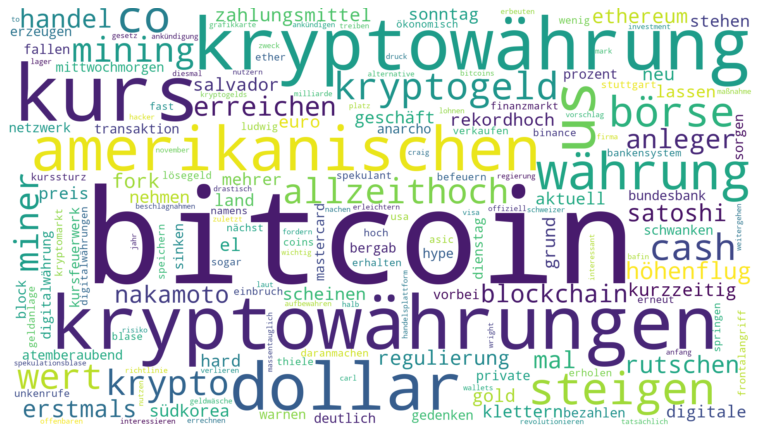
</div>
- Cluster 26 Fahrdienstvermittler (wie Uber oder Lyft)
- Cluster 27 Online-Handel/Amazon
- Cluster 29 USA/Präsident/Trump
- Cluster 30 VW-Skandal
- Cluster 31 Geschäftszahlen
- Cluster 32 Start-Ups
- Cluster 33 Elon Musk
- Cluster 38 Corona
- Cluster 39 VW-Skandal

Auffällig ist auch das der VW-Skandal in Cluster 19, 30 und 39 thematisiert wird. Es ist jedoch festzuhalten, dass das Clustering durchaus sinnvolle Ergebnisse zu bringen scheint.


In [ ]:
print("Top terms per cluster:")
order_centroids = lemma_kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = lead_lemma_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Im folgenden sind die Cluster als WordCloud dargestellt. Je größer die Schrift desto höher der TFIDF-Wert des Wortes.

In [ ]:
for i in range (40):
    
    print("Cluster %d:" % i)
    
    term_tfidf = {term: value for term, value in  zip(terms, lemma_kmeans_model.cluster_centers_[i])}
    
    wordcloud = WordCloud(background_color="white",width=1920, height=1080, max_words=175).generate_from_frequencies(term_tfidf)
    plt.figure(figsize=(12, 7), dpi=80)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Beispielhafte Einordnung von Texten in die Cluster

In [ ]:
# https://www.tagesschau.de/wirtschaft/unternehmen/usa-ruecktritt-bezos-amazon-101.html
text = """Amazon-Chef Jeff Bezos hat überraschend angekündigt, seinen Vorstandsvorsitz abzugeben.
Und das zu einer absoluten Rekordzeit für das Unternehmen.
Im Hintergrund könnte er jedoch weiter die Fäden ziehen."""
Y = lead_lemma_vectorizer.transform([text])
prediction = lemma_kmeans_model.predict(Y)
print(f"Cluster {prediction}")
print(text)
term_tfidf = {term: value for term, value in  zip(terms, lemma_kmeans_model.cluster_centers_[prediction[0]])}

wordcloud = WordCloud(background_color="white",width=1920, height=1080, max_words=175).generate_from_frequencies(term_tfidf)
plt.figure(figsize=(9, 4), dpi=50)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

text = """Warum Tesla-Chef Musk kurzfristig zum Fabrikgelände in Grünheide kam, ließ er offen.
Probleme gibt es am neuen Standort aber genug.
Seinen Fans war die Begegnung am Bauzaun wichtiger."""

#https://www.tagesschau.de/wirtschaft/unternehmen/musk-besuch-in-gruenheide-101.html
Y = lead_lemma_vectorizer.transform([text])
prediction = lemma_kmeans_model.predict(Y)
print(f"Cluster {prediction}")
print(text)
term_tfidf = {term: value for term, value in  zip(terms, lemma_kmeans_model.cluster_centers_[prediction[0]])}

wordcloud = WordCloud(background_color="white",width=1920, height=1080, max_words=175).generate_from_frequencies(term_tfidf)
plt.figure(figsize=(9, 4), dpi=50)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Größe der Cluster
Wie zu erkennen ist, gibt es ein großes Ungleichgewicht in der Anzahl der zu einem Cluster gehörenden Leads, zugunsten des dritten Clusters. Auch Experimente mit deutlich mehr bzw. deutlich weniger Cluster ergaben ein ähnliches Bild.
<div>
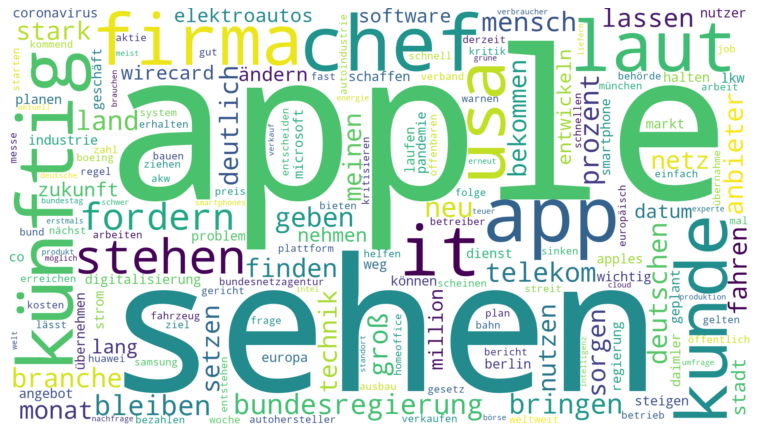
</div>

In [ ]:
lead_cluster_df = pd.DataFrame(lead_list_lemma, columns = ['lead'])
lead_cluster_df['cluster'] = lemma_kmeans_model.labels_

In [ ]:
lead_cluster_freq_df = lead_cluster_df.groupby(["cluster"]).count()
lead_cluster_freq_df = lead_cluster_freq_df.reset_index()
lead_cluster_freq_df = lead_cluster_freq_df.rename(columns={"lead":"anzahl_leads"})
lead_cluster_freq_df = lead_cluster_freq_df.sort_values(by='anzahl_leads',ascending=False)
lead_cluster_freq_df.head(10)

In [ ]:
fig = px.bar(lead_cluster_freq_df.astype({'cluster': 'str'}), x= 'cluster', y = 'anzahl_leads')
fig.show()

### Vergleich mit Überschneidungen der verwandten Themen
Die Venn-Diagramme visualisieren Themenüberschneidungen von über 50%. Es ist zu erkennen, dass es keine 100% Überschneidung gibt, was auch zu erwarten war, da es Cluster mit ähnlichen Themenbereichen gibt. Zudem wird jedem Artikel ein eindeutiger Cluster zugewiesen; einem Artikel können jedoch beliebig viele verwandte Themen zugeordnet werden.<br>
<b>Beispiele sind u.a.:</b><br>
<b>Cluster 10</b> hat u.a. große Überschneidungen mit den Themen "Social Media", "Facebook", "Mark Zuckerberg" und "Facebook-Datenskandal". Dies deckt sich thematisch auch mit den wichtigsten Worten.
<div>
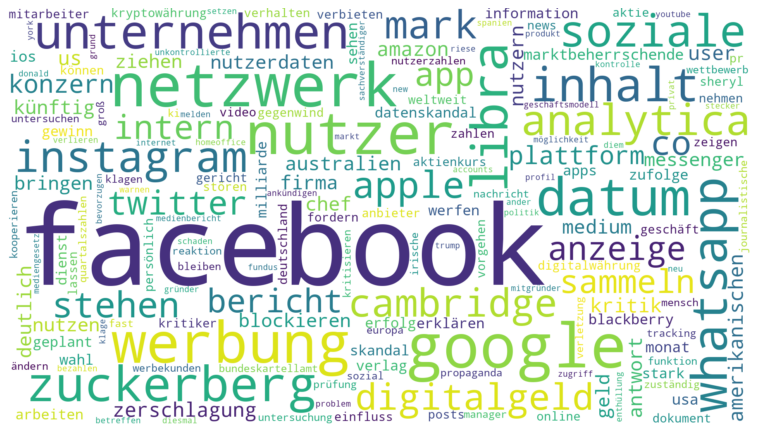
</div>
<b>Cluster 25</b> hat u.a. große Überschneidungen mit den Themen "Bitcoin" und "Kryptowährung".
<div>
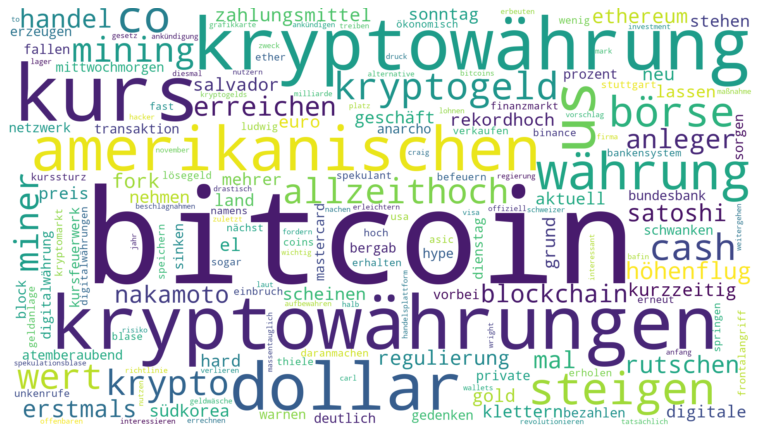
</div>

(Verwandte Themen denen nur sehr wenig Leads zugeordnet werden können, wurden nicht visualisiert, da es sonst zu viele Überschneidungen gäbe und somit ein guter Überblick verloren ginge)


In [ ]:
# dictionary mit Thema als Key und die Menge der zugehörigen Artikel-/Leadindizes
topic_articles = {}

for i, article in  enumerate(articles):
    related_topics = article["related_topics"]
    for topic in related_topics:
        topic_articles[topic] = topic_articles.get(topic,[]) + [i]  

In [ ]:
cluster_leads = {}
for i, label in enumerate(lemma_kmeans_model.labels_):
    label = f"Cluster {label}"
    cluster_leads[label] = cluster_leads.get(label,[]) + [i]

In [ ]:
def plot_word_cloud(cluster):
    
    print("="*100)
    print(f"Cluster: {cluster_key}")
    
    term_tfidf = {term: value for term, value in  zip(terms, lemma_kmeans_model.cluster_centers_[cluster])}
    
    wordcloud = WordCloud(background_color="white",width=1920, height=1080, max_words=175).generate_from_frequencies(term_tfidf)
    plt.figure(figsize=(10, 5), dpi=80)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
for cluster_key, value in cluster_leads.items():
    word_cloud_plotted = False
    
    cluster_lead_ind = set(value)
    
    for topic_key, value in topic_articles.items():
        
        topic_lead_ind = set(value)
        intersection_set_len = len(cluster_lead_ind.intersection(topic_lead_ind))
        
        # Um zu kleine Themen nicht zu visualisieren
        if (1 > len(topic_lead_ind) / len(cluster_lead_ind) > 0.05) or (1 > len(cluster_lead_ind)/len(topic_lead_ind) > 0.05):
            if intersection_set_len / len(cluster_lead_ind) > 0.5:
                if not word_cloud_plotted:
                    plot_word_cloud(int(cluster_key[-2:]))
                word_cloud_plotted = True
                venn2([cluster_lead_ind,topic_lead_ind], set_labels = [f"Cluster: {cluster_key}", topic_key])
                plt.show()


            elif intersection_set_len / len(topic_lead_ind) > 0.5:
                if not word_cloud_plotted:
                    plot_word_cloud(int(cluster_key[-2:]))
                word_cloud_plotted = True
                venn2([cluster_lead_ind,topic_lead_ind], set_labels = [f"Cluster: {cluster_key}", topic_key])
                plt.show()

### Veränderung über die Zeit
Die Balkendiagramme zeigen die Veränderung der Themen gemäß der Cluster nach der Zeit. Im zweiten Diagramm wurde Cluster 3 nicht visualisiert, um einen besseren Überblick über die anderen Cluster-Themen zu bekommen. Ähnlich wie bei den verwandten Themen (im Exploration Notebook zu sehen) ist beispielsweise Cluster 22, welcher viele Apple-Vokabel enthält, genau wie das verwandte Themen "Apple" über alle Jahre präsent. Am interessantesten ist jedoch Cluster 38, welcher die Thematik Corona umfasst und erstmals 2020 auftritt. Der KMeans-Algorithmus hat folglich die Corona-Krise in den Daten sehr gut entdeckt und eingeordnet.

(Zum besseren Verständnis sind unter den Schaubildern nochmals die Cluster und ihre Thematik aufgelistet.)


In [ ]:
date = [datetime.strptime(article["date"], "%m-%d-%Y, %H:%M").year for article in articles]
date_df= pd.DataFrame(date, columns =['year'])
lead_cluster_year = pd.concat([lead_cluster_df, date_df], axis=1).drop(labels=["lead"],axis=1)

In [ ]:
year_cluster_freq_df = lead_cluster_year.groupby(['year','cluster']).size().groupby('year', group_keys=False).nlargest(5).reset_index(name="frequency")
# Nur die Jahre 2017 bis 2021
year_cluster_freq_df = year_cluster_freq_df[year_cluster_freq_df.year.isin(range(2017,2022))]
year_cluster_freq_df = year_cluster_freq_df.astype({'cluster': 'str'})
fig = px.bar(year_cluster_freq_df, x="year", y="frequency", color="cluster", title="Anzahl Artikel Veröffenlichung nach Top 5 Cluster")
fig.show()

# Ohne Cluster 3
df = lead_cluster_year[lead_cluster_year.cluster != 3]
year_cluster_freq_df = df.groupby(['year','cluster']).size().groupby('year', group_keys=False).nlargest(5).reset_index(name="frequency")
# Nur die Jahre 2017 bis 2021
year_cluster_freq_df = year_cluster_freq_df[year_cluster_freq_df.year.isin(range(2017,2022))]
year_cluster_freq_df = year_cluster_freq_df.astype({'cluster': 'str'})
fig = px.bar(year_cluster_freq_df, x="year", y="frequency", color="cluster", title="Anzahl Artikel Veröffenlichung nach Top 5 Cluster (ohne Cluster 3)")
fig.show()

- Cluster 29 USA/Präsident/Trump
- Cluster 17 EU
- Cluster 27 Online-Handel/Amazon
- Cluster 15 IT /Digitalisierung
- Cluster 22 Apple
- Cluster 38 Corona

### Visualisierung der Cluster mittels PCA
<b>2D</b><br>
Im Zweidimensinalen erkennt man, dass sich Cluster 0, 8 und 29 von den anderen Clustern abheben. Die anderen Cluster sind in dieser Dimensinalität aber räumlich kaum getrennt.

- Cluster 0: dollar, us, amerikanischen, milliarde, million, apple, quartal, gewinn, iphone, wert
- Cluster 8: umsatz, prozent, quartal, gewinn, steigern, steigen, deutlich, sinken, aktie, anleger
- Cluster 29: us, amerikanischen, präsident, trump, regierung, huawei, konzern, unternehmen, apple, usa

<b>3D</b><br>
Im dreidimensionalen zeigt sich das gleiche Bild.

In [ ]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(lead_lemma_tfidf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(lemma_kmeans_model.cluster_centers_)

In [ ]:
fig = go.Figure()   

lead_clusters = px.scatter(x=reduced_features[:,0], y=reduced_features[:,1],color=lemma_kmeans_model.labels_.astype("str"))

for cluster in lead_clusters.data:
    fig.add_trace(cluster)
    
for cluster in lead_clusters.data:
    cluster_num = int(cluster["name"])
    fig.add_trace(go.Scattergl(
        mode='markers',
        name = cluster["name"],
        marker_symbol = "x",
        marker_size = 15,
        marker_color = cluster["marker"]["color"],
        marker_line = dict(
                color='Black',
                width=2
            ),
        x=[reduced_cluster_centers[cluster_num,0]],
        y=[reduced_cluster_centers[cluster_num,1]]
        ))

fig.show()

In [ ]:
# reduce the features to 3D
pca_3d = PCA(n_components=3, random_state=0)
reduced_features_3d = pca_3d.fit_transform(lead_lemma_tfidf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_3d = pca_3d.transform(lemma_kmeans_model.cluster_centers_)

In [ ]:
fig = go.Figure()   

lead_clusters = px.scatter_3d(x=reduced_features_3d[:,0], y=reduced_features_3d[:,1], z=reduced_features_3d[:,2], color=lemma_kmeans_model.labels_.astype("str"))
    
for cluster in lead_clusters.data:
    
    fig.add_trace(cluster)
    
    cluster_num = int(cluster["name"])
    fig.add_trace(go.Scatter3d(
        mode='markers',
        name = cluster["name"],
        marker_symbol = "x",
        marker_size = 15,
        marker_color = cluster["marker"]["color"],
        marker_line = dict(
                color='Black',
                width=2
            ),
        x=[reduced_cluster_centers_3d[cluster_num,0]],
        y=[reduced_cluster_centers_3d[cluster_num,1]],
        z =[reduced_cluster_centers_3d[cluster_num,2]]
        ))

fig.show()

Abschließend kann festgehalten werden, dass das unüberwachte Clustering der Texte durchaus thematisch sinnvolle Cluster erzeugt. Die Cluster weißen Überschneidungen mit den verwandten Themen auf und auch die Coronakrise konnte aus den Texten extrahiert werden. Allerdings fällt auf, dass es ein Ungleichgewicht der Größen der Cluster zugunsten des Cluster 3 gibt.

# Clustering anhand des Textes
Da die Texte wesentlich länger sind und somit auch einen deutlich größeren Wortschatz (141320 Wörter) umfassen, sind das Vorverarbeiten und das Clustering wesentlich rechenintensiver. Folglich wird auf Erkenntnisse aus dem Clustering der Leads zurückgegriffen und die Cluster-Analyse nicht so detailliert ausfallen.

## Vorverarbeitung

### Tokenisierung und Bereinigung

In [ ]:
text_article = [article["atricle_text"] for article in articles]

In [ ]:
# removing stopwords
text_list = []
for text in tqdm(text_article):
    text_tokens = nltk.word_tokenize(text)
    text = " ".join([w for w in text_tokens if not w.lower() in STOP_WORDS])
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub(r'[0-9]+', '', text)
    # remove all multiple white spaces
    text_list.append(" ".join(text.split()))

### Lemmatisierung

In [ ]:
# Lemmatisierung
# text_list_lemma = []
# for text in tqdm(text_list):
#     text_list_lemma.append(" ".join([token.lemma_ for token in nlp(text)]))
    
#pk.dump(text_list_lemma, open(os.path.join("dumped_files","text_list_lemma.pkl"),"wb"))

text_list_lemma = pk.load(open(os.path.join("dumped_files","text_list_lemma.pkl"),'rb'))

### Vektorisierung
Da es wesentlich mehr Merkmale gibt als im Falle des Lead-Clusterings, wird auch mit einem Vektor experimentiert, der nur aus einem Vokabular von 5000 Wörtern besteht.

In [ ]:
text_lemma_vectorizer = TfidfVectorizer()
text_lemma_tfidf = text_lemma_vectorizer.fit_transform(text_list_lemma)

text_lemma_vectorizer_5k = TfidfVectorizer(max_features=5000)
text_lemma_tfidf_5k = text_lemma_vectorizer_5k.fit_transform(text_list_lemma)

In [ ]:
pd.DataFrame(text_lemma_tfidf.toarray(), columns=text_lemma_vectorizer.get_feature_names())

In [ ]:
pd.DataFrame(text_lemma_tfidf_5k.toarray(), columns=text_lemma_vectorizer_5k.get_feature_names())

## Finden der besten Cluster-Anzahl

Mittels der Ellenbogen-Methode lässt sich für die Texte ein k = 60 ermitteln. Wird die Kurve mit der der Leads verglichen, zeigt sich, dass das K bei den Texten durchaus höher liegen muss als das k der Leads. Aus dem reduzierten Vektor ergeben sich keine merklich besseren Cluster-Tendenzen.  

In [ ]:
#distortions = []
K = range(1,300)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=42, n_init=10, batch_size=1000)
#     kmeanModel.fit(text_lemma_tfidf)
#     distortions.append(kmeanModel.inertia_)

#pk.dump(distortions, open(os.path.join("dumped_files","text_lemma_distortions_300.pkl"),"wb"))

distortions = pk.load(open(os.path.join("dumped_files","text_lemma_distortions_300.pkl"),'rb'))

trendline = px.scatter(x=K, y=distortions, trendline="ols") #,trendline_scope="overall") # trendline_options=dict(log_x=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(K), y=pk.load(open(os.path.join("dumped_files","lead_lemma_distortions_300.pkl"),'rb')),
                    mode='lines+markers',
                    marker_color="green",
                    name="lead distortions"))

fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers',
                    name="text distortions"))

fig.add_trace(trendline.data[1])
fig.show()

In [ ]:
#distortions = []
K = range(1,300)
# for k in K:
#     clear_output(wait=True)
#     display(f"Iteration {k}")
#     kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=42, n_init=10, batch_size=1000)
#     kmeanModel.fit(text_lemma_tfidf_5k)
#     distortions.append(kmeanModel.inertia_)

# pk.dump(distortions, open(os.path.join("dumped_files","text_lemma_distortions_300_5k.pkl"),"wb"))

distortions = pk.load(open(os.path.join("dumped_files","text_lemma_distortions_300_5k.pkl"),'rb'))

trendline = px.scatter(x=K, y=distortions, trendline="ols") #, trendline_options=dict(log_x=True),trendline_scope="overall")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=pk.load(open(os.path.join("dumped_files","lead_lemma_distortions_300.pkl"),'rb')),
                    mode='lines+markers',
                    marker_color="green",
                    name="lead distortions"))

fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers',
                    name="text distortions"))
fig.add_trace(trendline.data[1])
fig.show()

## Finales Clustering + Analyse

In [ ]:
#true_k = 60
#text_lemma_kmeans_model = KMeans(n_clusters=true_k,random_state=42, n_init=20)
#text_lemma_kmeans_model.fit(text_lemma_tfidf)

#pk.dump(text_lemma_kmeans_model, open(os.path.join("dumped_files","text_lemma_kmeans_model.pkl"),"wb"))

text_lemma_kmeans_model = pk.load(open(os.path.join("dumped_files","text_lemma_kmeans_model.pkl"),'rb'))

### Wichtigste Wörter gemäß TFIDF


In [ ]:
print("Top terms per cluster:")
order_centroids = text_lemma_kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = text_lemma_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Im folgenden sind die Cluster als WordCloud dargestellt. Je größer die Schrift desto höher der TFIDF-Wert des Wortes.

In [ ]:
for i in range (60):
    
    print("Cluster %d:" % i)
    
    term_tfidf = {term: value for term, value in  zip(terms, text_lemma_kmeans_model.cluster_centers_[i])}
    
    wordcloud = WordCloud(background_color="white",width=1920, height=1080, max_words=175).generate_from_frequencies(term_tfidf)
    plt.figure(figsize=(12, 7), dpi=80)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Auch hier können die meisten Cluster einem Thema zugeordnet werden. Bei manchen ist es teilweise nicht eindeutig, bei anderen überschneiden sich die Themen. So bei Thema ''Apple'' (Cluster: 51,1 und 17) oder ''Automobil-Industrie'' (Cluster: 10,20 und 46), bzw. ''Elektromobilität'' (Cluster: 43, 58) sowie ''Netz und Mobilfunk'' (Cluster: 59,57,26). Die Häufigkeit speziell dieser Themen überschneidet sich mit den Ergebnissen der vorherigen Analysen. 

Folgende Cluster konnten Themen zugeordnet werden: 
- Cluster 0 Gigafabrik Tesla in Grünheide
- Cluster 1 Apple
- Cluster 2 VW 
- Cluster 3 China Wirtschaft 
- Cluster 5 Smartphones 
- Cluster 6 USA Wirtschaft 
- Cluster 9 Telekom Übernahme von Sprint
- Cluster 10 Automobil-Industrie
- Cluster 11 Heise Show
- Cluster 12 Diesel Fahrverbot
- Cluster 13 Facebook
- Cluster 15 China und USA Wirtschaft 
- Cluster 16 USA Börse
- Cluster 17 Apple
- Cluster 18 CO2 Ausstoß
- Cluster 19 Online Handel 
- Cluster 20 Automobil-Industrie 
- Cluster 21 künstliche Intelligenz 
- Cluster 22 Gender Gap 
- Cluster 25 Cebit in Hannover 
- Cluster 26 Mobilfunk 
- Cluster 27 Wirtschaft 
- Cluster 29 Microsoft 
- Cluster 30 Tiktok Verbot USA
- Cluster 31 wirecard Skandal
- Cluster 34 Flugzeug Industrie 
- Cluster 35 Verdi Amazon Streik
- Cluster 36 Kryptowährungen
- Cluster 37 Moderner Straßenverkehr
- Cluster 38 Bundesregierung Deutschland
- Cluster 39 Prozessoren Hersteller
- Cluster 40 EU 
- Cluster 43 Elektroautos
- Cluster 44 Grafikkarten
- Cluster 45 Atomkraft 
- Cluster 46 Daimler, Automobil-Industrie
- Cluster 47 Tesla
- Cluster 48 Energie
- Cluster 49 Städtischer Verkehr 
- Cluster 51 Apple
- Cluster 54 Rundfunk Deutschland
- Cluster 55 Amazon 
- Cluster 57 Mobilfunk/Netzanbieter 
- Cluster 58 Elektroautos 
- Cluster 59 Netzausbau


### Größe der Cluster

In [ ]:
text_cluster_df = pd.DataFrame(text_list_lemma, columns = ['text'])
text_cluster_df['cluster'] = text_lemma_kmeans_model.labels_

In [ ]:
text_cluster_freq_df = text_cluster_df.groupby(["cluster"]).count()
text_cluster_freq_df = text_cluster_freq_df.reset_index()
text_cluster_freq_df = text_cluster_freq_df.rename(columns={"text":"anzahl_texte"})
text_cluster_freq_df = text_cluster_freq_df.sort_values(by='anzahl_texte',ascending=False)
text_cluster_freq_df.head(10)

In [ ]:
fig = px.bar(text_cluster_freq_df.astype({'cluster': 'str'}), x= 'cluster', y = 'anzahl_texte')
fig.show()

Die meisten Texte können dem Cluster Nummer 4 zugewiesen werden. Dieser Cluster ist schwer zu definieren, kann aber grob der Rubrik ''Wirtschaft'' zugeordnet werden. Der Cluster mit den zweitmeisten Texten ist der Wirtschaft in den USA zuzuordnen, Cluster Nummer 38, der an dritter Stelle steht, befasst sich mit den Themen der deutschen Bundesregierung. Nach den vorherigen Analysen hätte vielleicht erwartet werden können, dass Themen wie Elektromobilität hier auf Platz eins stehen. Jedoch sind diese Themen wie bereits beobachtet in mehrere kleinere Cluster aufgeteilt, und fallen in dieser Statistik deshalb weniger auf.

### Vergleich mit Überschneidungen der verwandten Themen

In [ ]:
# dictionary mit Thema als Key und die Menge der zugehörigen Artikel-/Leadindizes
topic_articles = {}

for i, article in  enumerate(articles):
    related_topics = article["related_topics"]
    for topic in related_topics:
        topic_articles[topic] = topic_articles.get(topic,[]) + [i]  

In [ ]:
cluster_texts = {}
for i, label in enumerate(text_lemma_kmeans_model.labels_):
    label = f"Cluster {label}"
    cluster_texts[label] = cluster_texts.get(label,[]) + [i]

In [ ]:
def plot_word_cloud(cluster):
    
    print("="*100)
    print(f"Cluster: {cluster_key}")
    
    term_tfidf = {term: value for term, value in  zip(terms, text_lemma_kmeans_model.cluster_centers_[cluster])}
    
    wordcloud = WordCloud(background_color="white",width=1920, height=1080, max_words=175).generate_from_frequencies(term_tfidf)
    plt.figure(figsize=(10, 5), dpi=80)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
for cluster_key, value in cluster_texts.items():
    word_cloud_plotted = False
    
    cluster_text_ind = set(value)
    
    for topic_key, value in topic_articles.items():
        
        topic_text_ind = set(value)
        intersection_set_len = len(cluster_text_ind.intersection(topic_text_ind))
        
        # Um zu kleine Themen nicht zu visualisieren
        if (1 > len(topic_text_ind) / len(cluster_text_ind) > 0.05) or (1 > len(cluster_text_ind)/len(topic_text_ind) > 0.05):
            if intersection_set_len / len(cluster_text_ind) > 0.5:
                if not word_cloud_plotted:
                    plot_word_cloud(int(cluster_key[-2:]))
                word_cloud_plotted = True
                venn2([cluster_text_ind,topic_text_ind], set_labels = [f"Cluster: {cluster_key}", topic_key])
                plt.show()


            elif intersection_set_len / len(topic_text_ind) > 0.5:
                if not word_cloud_plotted:
                    plot_word_cloud(int(cluster_key[-2:]))
                word_cloud_plotted = True
                venn2([cluster_text_ind,topic_text_ind], set_labels = [f"Cluster: {cluster_key}", topic_key])
                plt.show()

Auch hier wurden Venn-Diagramme erstellt um die Überschneidungen der Themen
zu vergleichen. Schon Bei Cluster 51 ist zu bemerken, dass er nahezu komplett 
in dem Topic Apple liegt (99,5 %). Die größte Ähnlichkeit besteht zwischen dem Topic Streik und Cluster 35, hier gibt es 85,7 % Überschneidungen. 
Es lässt sich festhalten, die Topics unterscheiden sich schon von den Clustern, jedoch lassen sich teilweise Cluster zu 100 % einem Topic zuordnen (Cluster 36 befindet sich vollständig in Topic ''Kryptowährung''), dies ist durchaus ein sehr gutes Ergebnis.

### Veränderung über die Zeit

In [ ]:
date = [datetime.strptime(article["date"], "%m-%d-%Y, %H:%M").year for article in articles]
date_df= pd.DataFrame(date, columns =['year'])
text_cluster_year = pd.concat([text_cluster_df, date_df], axis=1).drop(labels=["text"],axis=1)

In [ ]:
year_cluster_freq_df = text_cluster_year.groupby(['year','cluster']).size().groupby('year', group_keys=False).nlargest(5).reset_index(name="frequency")
# Nur die Jahre 2017 bis 2021
year_cluster_freq_df = year_cluster_freq_df[year_cluster_freq_df.year.isin(range(2017,2022))]
year_cluster_freq_df = year_cluster_freq_df.astype({'cluster': 'str'})
fig = px.bar(year_cluster_freq_df, x="year", y="frequency", color="cluster", title="Anzahl Artikel Veröffenlichung nach Top 5 Cluster")
fig.show()

Die großen Themen Wirtschaft und Wirtschaft in den USA (Cluster 4 und 6) sind in jedem Jahr sehr häufig vertreten. Cluster 40, welcher dem Thema ''EU'' zugeordnet werden kann, ist nur in 2017 und 2018 vertreten, dies könnte dem Start der Diskussionen über den Brexit zuzuordnen sein. 2018 war der Diesel-Skandal,  dieser könnte zu häufigem Auftreten des Cluster 12 geführt haben (Diesel Fahrverbote), sowie der Start der Pandemie 2020 zu häufigen Umfragen im Bereich Lebensqualität (Cluster 32). 
Zu erkennen ist deutlich, die Cluster machen Sinn und lassen sich sogar großenteils Ereignissen zuordnen. Speziell kleinere Cluster lassen sich mit bestimmten Geschehnissen verbinden.


### Visualisierung der Cluster mittels PCA

In [ ]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(text_lemma_tfidf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(text_lemma_kmeans_model.cluster_centers_)

In [ ]:
fig = go.Figure()   

text_clusters = px.scatter(x=reduced_features[:,0], y=reduced_features[:,1],color=text_lemma_kmeans_model.labels_.astype("str"))

for cluster in text_clusters.data:
    fig.add_trace(cluster)
    
for cluster in lead_clusters.data:
    cluster_num = int(cluster["name"])
    fig.add_trace(go.Scattergl(
        mode='markers',
        name = cluster["name"],
        marker_symbol = "x",
        marker_size = 15,
        marker_color = cluster["marker"]["color"],
        marker_line = dict(
                color='Black',
                width=2
            ),
        x=[reduced_cluster_centers[cluster_num,0]],
        y=[reduced_cluster_centers[cluster_num,1]]
        ))

fig.show()

In [ ]:
# reduce the features to 3D
pca_3d = PCA(n_components=3, random_state=0)
reduced_features_3d = pca_3d.fit_transform(text_lemma_tfidf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_3d = pca_3d.transform(text_lemma_kmeans_model.cluster_centers_)

In [ ]:
fig = go.Figure()   

text_clusters = px.scatter_3d(x=reduced_features_3d[:,0], y=reduced_features_3d[:,1], z=reduced_features_3d[:,2], color=text_lemma_kmeans_model.labels_.astype("str"))
    
for cluster in lead_clusters.data:
    
    fig.add_trace(cluster)
    
    cluster_num = int(cluster["name"])
    fig.add_trace(go.Scatter3d(
        mode='markers',
        name = cluster["name"],
        marker_symbol = "x",
        marker_size = 15,
        marker_color = cluster["marker"]["color"],
        marker_line = dict(
                color='Black',
                width=2
            ),
        x=[reduced_cluster_centers_3d[cluster_num,0]],
        y=[reduced_cluster_centers_3d[cluster_num,1]],
        z =[reduced_cluster_centers_3d[cluster_num,2]]
        ))

fig.show()

# Ähnlichste Artikel finden 

Dieser Codeabschnitt ist lediglich eine kleine Spielerei, und findet zu einem zufälligen Artikel, den ähnlichsten Artikel im Datensatz. Um den Vorgang zu vereinfachen wird hier mit den Leads gearbeitet. 

In [ ]:

documents = lead_list_lemma

vectorizer = TfidfVectorizer(stop_words=STOP_WORDS)
X = vectorizer.fit_transform(documents)

pairwise_similarity = X * X.T

In [ ]:
pairwise_similarity = X * X.T

arr = pairwise_similarity.toarray()     
np.fill_diagonal(arr, np.nan) 

In [ ]:
input_idx = randint(0,len(lead_list_lemma))
result_idx = np.nanargmax(arr[input_idx])                                                                                                                                                                                                                
print('Input: \n' + lead_article[input_idx]+ '\n')                                                                                                                                                                                                                                     
print('Output: \n'+ lead_article[result_idx])

# Fazit

Es lässt sich letztendlich sagen, dass das Clustering durchaus sinnvolle und interessante Ergebnisse liefert. Außerdem konnte festgestellt werden, dass auch mit den Kurzbeschreibungen sinnvolle und aussagekräftige Cluster erstellt werden können, und das trotz ihren wenigen Wörtern. Die Ergebnisse lassen sich mit realen Ereignissen in Verbindung bringen und überschneiden sich durchaus mit den durch die Heise Redaktion zugeordneten Themen (related topics). Jedoch ist Auffällig, dass es nach dem Clustering einzelne sehr große Cluster gibt, die einen Großteil der Artikel abdecken. In einem weiteren Projekt könnte versucht werden, diese großen Cluster erneut in kleinere spezifische Cluster zu unterteilen.
Das Projekt konnte somit erfolgreich abgeschlossen werden.
